## Eredmény jóslat különböző ML algoritmusok felhasználásával

https://github.com/tunghoangt/Soccer-prediction-with-Machine-Learning/blob/master/models/Presentation.ipynb alapján

In [1]:
import pandas as pd
from segedfgek import *
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from SBS import *
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

from PlotDecisionRegions import *
from sklearn.decomposition import PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import KernelPCA

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, LassoLars, Ridge, BayesianRidge, SGDRegressor, LinearRegression
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV

# to supress warnings
import warnings
warnings.filterwarnings('ignore')

### Adatelőkészítés

In [2]:
df1920=pd.read_csv('.\Adatgyűjtés\Adatgyűjtés\Adatok\OTPBankLigaAdatok_1516_1920\OTPBankLigaAdatok1920')
df1920 = df1920[::-1]
df1920['HLabdabirtoklás'] = df1920['HLabdabirtoklás'].map(lambda x: x.rstrip('%'))
df1920['ILabdabirtoklás'] = df1920['ILabdabirtoklás'].map(lambda x: x.rstrip('%'))
df1920['target'] = df1920[['HGólok', 'IGólok']].apply(score_to_win, axis = 1)
df1920['Dátum'] = '2019' #egyszerűbb a későbbiekben csak a szezon kezdetének évét használni a teljes dátum helyett
df1920.head()

,Dátum,HCsapat,ICsapat,HGólok,IGólok,HLabdabirtoklás,ILabdabirtoklás,HKapuraLövés,IKapuraLövés,HKaputEltalálóLövések,...,IKaputNEMTL,HSzabadrúgás,ISzabadrúgás,HSzöglet,ISzöglet,HBedobás,IBedobás,HVédés,IVédés,target
197,2019,Újpest,Puskás Akadémia,1,3,70,30,9,9,2,...,4,19,9,7,1,45,13,2,1,-1
196,2019,Mezőkövesd,Zalaegerszeg,1,0,46,54,11,10,4,...,7,13,19,5,5,17,29,3,3,1
195,2019,Kisvárda,Paks,1,0,39,61,9,6,3,...,3,9,17,8,7,24,30,3,2,1
194,2019,MOL Fehérvár FC,Kaposvár,4,2,65,35,13,5,9,...,3,19,7,9,3,21,12,0,5,1
193,2019,Diósgyőri VTK,Honvéd FC,2,1,48,52,10,11,5,...,6,14,15,6,11,20,18,4,3,1


In [3]:
df1718=pd.read_csv('.\Adatgyűjtés\Adatgyűjtés\Adatok\OTPBankLigaAdatok_1516_1920\OTPBankLigaAdatok1718')
df1718 = df1718[::-1]
df1718['Dátum'] = '2017'
df1718.head()

,Dátum,HCsapat,ICsapat,HGólok,IGólok,HLabdabirtoklás,ILabdabirtoklás,HKapuraLövés,IKapuraLövés,HKaputEltalálóLövések,...,HKaputNEMTL,IKaputNEMTL,HSzabadrúgás,ISzabadrúgás,HSzöglet,ISzöglet,HBedobás,IBedobás,HVédés,IVédés
197,2017,Paks,Újpest,2,2,54%,46%,9,10,4,...,5,5,23,22,9,1,30,21,3,2
196,2017,Debreceni VSC,Mezőkövesd,1,2,48%,52%,18,9,9,...,9,3,16,20,8,3,36,22,4,8
195,2017,Honvéd FC,Haladás,2,0,54%,46%,7,1,5,...,2,1,24,23,7,1,27,23,0,3
194,2017,Vasas,Diósgyőri VTK,0,2,47%,53%,8,10,4,...,4,5,25,22,2,3,24,35,3,4
193,2017,MOL Fehérvár FC,Balmazújváros,1,1,56%,44%,14,8,4,...,10,5,19,11,5,2,30,26,2,3


In [4]:
df1718.loc[df1718['HVédés'] == 129]

,Dátum,HCsapat,ICsapat,HGólok,IGólok,HLabdabirtoklás,ILabdabirtoklás,HKapuraLövés,IKapuraLövés,HKaputEltalálóLövések,...,HKaputNEMTL,IKaputNEMTL,HSzabadrúgás,ISzabadrúgás,HSzöglet,ISzöglet,HBedobás,IBedobás,HVédés,IVédés
158,2017,Honvéd FC,Debreceni VSC,1,3,50%,50%,8,7,4,...,4,3,5,3,1,3,2,2,129,100


Egy meccsnél a lescrapelt adat elcsúszott egy sorral és a védések száma helyett a támadások száma került az adatba, ezt kézzel kijavítottam.

In [5]:
df1718['HVédés'] = df1718['HVédés'].replace([129],1)
df1718['IVédés'] = df1718['IVédés'].replace([100],3)

In [6]:
print(df1718.IVédés.unique())

[ 2  8  3  4  5  1  6  0  7 20  9 10 13]


In [7]:
df1819=pd.read_csv('.\Adatgyűjtés\Adatgyűjtés\Adatok\OTPBankLigaAdatok_1516_1920\OTPBankLigaAdatok1819')
df1819 = df1819[::-1]
df1819 = df1819.drop([197]) #most elhagyjuk a hiányos Kisvárda-Újpest meccset
df1819['Dátum'] = '2018'
df1819

,Dátum,HCsapat,ICsapat,HGólok,IGólok,HLabdabirtoklás,ILabdabirtoklás,HKapuraLövés,IKapuraLövés,HKaputEltalálóLövések,...,HKaputNEMTL,IKaputNEMTL,HSzabadrúgás,ISzabadrúgás,HSzöglet,ISzöglet,HBedobás,IBedobás,HVédés,IVédés
196,2018,Puskás Akadémia,Debreceni VSC,0,1,49%,51%,4,10,1,...,3,5,18,18,4,10,26,24,4,1
195,2018,MOL Fehérvár FC,Kisvárda,4,0,51%,49%,19,6,11,...,8,2,11,13,8,0,17,14,4,7
194,2018,Mezőkövesd,Paks,3,1,49%,51%,9,14,7,...,2,9,17,5,5,5,18,21,4,4
193,2018,Honvéd FC,Haladás,3,2,55%,45%,18,14,11,...,7,8,20,11,6,9,15,23,4,8
192,2018,Ferencvárosi TC,Diósgyőri VTK,4,1,57%,43%,21,9,13,...,8,4,15,22,12,3,17,17,4,9
191,2018,Újpest,MTK Budapest,0,2,56%,44%,6,14,2,...,4,5,12,15,10,3,29,13,7,2
190,2018,Diósgyőri VTK,Puskás Akadémia,2,2,51%,49%,12,8,8,...,4,3,19,21,7,2,1,2,3,6
189,2018,MOL Fehérvár FC,Paks,1,1,52%,48%,12,6,3,...,9,3,25,19,1,3,24,15,2,2
188,2018,Debreceni VSC,Mezőkövesd,1,1,54%,46%,7,7,4,...,3,3,15,17,6,8,18,17,3,3
187,2018,MTK Budapest,Ferencvárosi TC,1,4,56%,44%,7,8,4,...,3,3,18,16,6,4,19,26,4,3


In [8]:
train_df = pd.concat([df1718, df1819, df1920], ignore_index=True)
train_df['HLabdabirtoklás'] = train_df['HLabdabirtoklás'].map(lambda x: x.rstrip('%'))
train_df['ILabdabirtoklás'] = train_df['ILabdabirtoklás'].map(lambda x: x.rstrip('%'))
train_df['target'] = train_df[['HGólok', 'IGólok']].apply(score_to_win, axis = 1)
train_df[["Dátum","HGólok","IGólok","HLabdabirtoklás","ILabdabirtoklás","HKapuraLövés","IKapuraLövés",
"HKaputEltalálóLövések","IKaputEltalálóLövések","HKaputNEMTL","IKaputNEMTL","HSzabadrúgás","ISzabadrúgás","HSzöglet","ISzöglet",
"HBedobás","IBedobás","HVédés","IVédés"]] = train_df[["Dátum", "HGólok","IGólok","HLabdabirtoklás","ILabdabirtoklás","HKapuraLövés","IKapuraLövés",
"HKaputEltalálóLövések","IKaputEltalálóLövések","HKaputNEMTL","IKaputNEMTL","HSzabadrúgás","ISzabadrúgás","HSzöglet","ISzöglet",
"HBedobás","IBedobás","HVédés","IVédés"]].apply(pd.to_numeric)
train_df.head()

,Dátum,HBedobás,HCsapat,HGólok,HKapuraLövés,HKaputEltalálóLövések,HKaputNEMTL,HLabdabirtoklás,HSzabadrúgás,HSzöglet,...,ICsapat,IGólok,IKapuraLövés,IKaputEltalálóLövések,IKaputNEMTL,ILabdabirtoklás,ISzabadrúgás,ISzöglet,IVédés,target
0,2017,30,Paks,2,9,4,5,54,23,9,...,Újpest,2,10,5,5,46,22,1,2,0
1,2017,36,Debreceni VSC,1,18,9,9,48,16,8,...,Mezőkövesd,2,9,6,3,52,20,3,8,-1
2,2017,27,Honvéd FC,2,7,5,2,54,24,7,...,Haladás,0,1,0,1,46,23,1,3,1
3,2017,24,Vasas,0,8,4,4,47,25,2,...,Diósgyőri VTK,2,10,5,5,53,22,3,4,-1
4,2017,30,MOL Fehérvár FC,1,14,4,10,56,19,5,...,Balmazújváros,1,8,3,5,44,11,2,3,0


Előnyös egy táblába tenni az összes szezont, később egyszerre lesz, hogy több is kell és egyszerűbb kivenni, azt amelyikre nincs szükség. Hozzávettem ehhez még egy célváltozót, ami 1 hazai győzelem esetén, 0 döntetlenkor, -1 idegenbeli győzelemnél. 

Az 'X' feature mátrixunkhoz elhagyjuk a célváltozót és a nem integer típusú oszlopokat, illetve az eredményt is, hiszen ez közvetlenül határozza meg a célváltozót.

In [9]:
FEATURES_TO_DROP = ['target', 'Dátum', 'HCsapat', 'ICsapat', 'HGólok', 'IGólok']
train_df_wo = train_df.drop(columns = FEATURES_TO_DROP)
train_df_wo.head()

,HBedobás,HKapuraLövés,HKaputEltalálóLövések,HKaputNEMTL,HLabdabirtoklás,HSzabadrúgás,HSzöglet,HVédés,IBedobás,IKapuraLövés,IKaputEltalálóLövések,IKaputNEMTL,ILabdabirtoklás,ISzabadrúgás,ISzöglet,IVédés
0,30,9,4,5,54,23,9,3,21,10,5,5,46,22,1,2
1,36,18,9,9,48,16,8,4,22,9,6,3,52,20,3,8
2,27,7,5,2,54,24,7,0,23,1,0,1,46,23,1,3
3,24,8,4,4,47,25,2,3,35,10,5,5,53,22,3,4
4,30,14,4,10,56,19,5,2,26,8,3,5,44,11,2,3


### Adatvizualizáció

Szimmetrikusak a statisztikák, így most itt a hazai csapatok statisztikáit vizsgáljuk.

#### Páronkénti korreláció

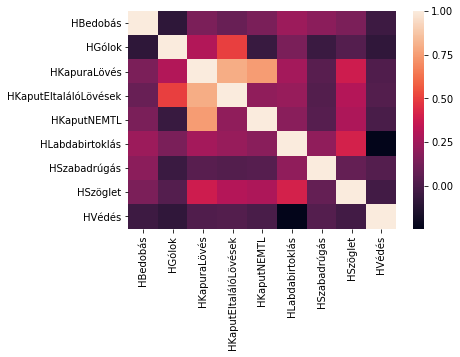

In [10]:
home_features = [ f for f in list(train_df) if 'H' in f ]
corr = train_df[home_features].corr()
sns.heatmap(corr)

A legnagyobb korrelációban a HGólok változóval a HKaputEltalálóLövések áll, ezt követné a HKapuraLövés. Viszont a 3 kapuralövési statisztikából, egyszerre elég lesz 2 is, mivel a pontos és pontatlan lövésekből már tudja a modell mennyi kapuralövés volt összesen.

#### A változók eloszlása

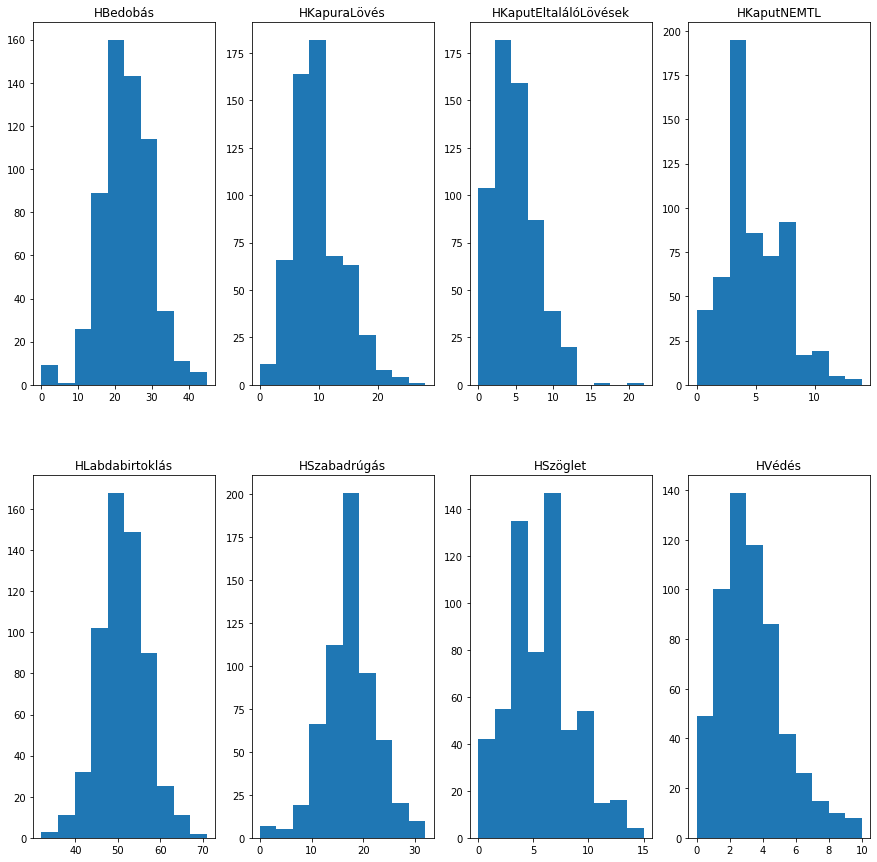

In [11]:
n_figs = len(home_features)
columns = 4

fig, axes = plt.subplots(int(n_figs/columns), columns, figsize = (15, 15))
plt.subplots_adjust(hspace = .25)

home_features = [ f for f in list(train_df_wo) if 'H' in f ]
for i, feature in enumerate(home_features):
    row = int(i / columns)
    column = i % columns
    axes[row, column].hist(train_df_wo[feature].values)
    axes[row, column].set_title(feature)

#### A célváltozó eloszlása

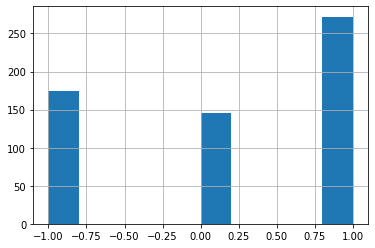

In [12]:
_ = train_df.target.hist()

A szerzett gólokkal legnagyobb korrelációban a kaput eltaláló lövések vannak, ezeknek kapcsolatáról részletesebben:

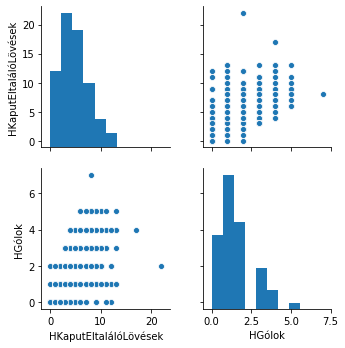

In [13]:
_ = sns.pairplot(train_df[['HKaputEltalálóLövések', 'HGólok']])

## Feature selection

### Feature fontosság

#### Random Forest

In [14]:
X = train_df_wo.values
y = train_df['target'].values
features = train_df_wo.columns
forest = RandomForestClassifier(n_estimators=500,random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, 
                                                                random_state = 42)

forest.fit(X_train, y_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
indices
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,features[indices[f]], importances[indices[f]]))

 1) IKaputEltalálóLövések          0.102542
 2) HKaputEltalálóLövések          0.097427
 3) HBedobás                       0.076402
 4) IBedobás                       0.066744
 5) HSzabadrúgás                   0.065443
 6) IKapuraLövés                   0.063815
 7) ISzabadrúgás                   0.061531
 8) HSzöglet                       0.056213
 9) HKaputNEMTL                    0.055751
10) IVédés                         0.054910
11) ISzöglet                       0.053520
12) HKapuraLövés                   0.052081
13) HVédés                         0.051609
14) ILabdabirtoklás                0.050613
15) HLabdabirtoklás                0.046729
16) IKaputNEMTL                    0.044671


Érdekes, hogy ez az algoritmus mekkora teret ad a bedobásoknak, szemben például a labdabirtoklással, amiről azt gondolnánk, hogy sokkal többet árul el a csapatok teljesítményéről.

### Sequential Backward Selection

Az SBS során a modellből egyesével dobáljuk ki a változókat, minden alkalommal megvizsgálva a pontosságot.

In [15]:
lr = LogisticRegression()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
knn = KNeighborsClassifier()

clf_labels = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'KNN']

all_clf = [lr, rf, gb, knn]

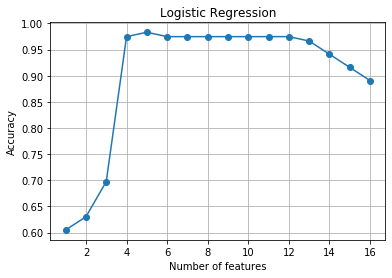

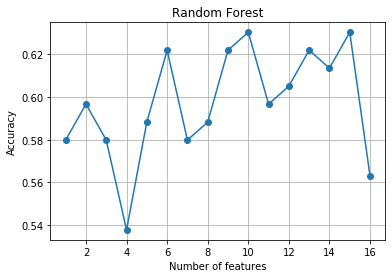

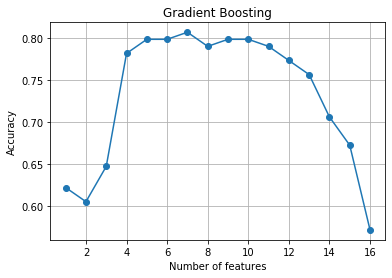

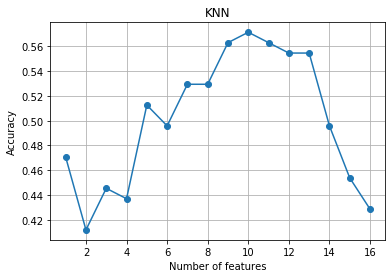

In [16]:
k_feat = {key: None for key in clf_labels}
sbs = {key: None for key in clf_labels}

for label, clf in zip(clf_labels, all_clf):
    sbs[label] = SBS(clf,k_features=1)
    sbs[label].fit(X_train,y_train)
    k_feat[label] = [len(k) for k in sbs[label].subsets_]
    plt.plot(k_feat[label], sbs[label].scores_, marker='o')
    #plt.ylim([0.3, 1.02])
    plt.title(label)
    plt.ylabel('Accuracy')
    plt.xlabel('Number of features')
    plt.grid()
    plt.show()

In [17]:
print("List of 5 features that will achieve highest accuracy for Logistic Regression: \n")
lr_features = list(sbs['Logistic Regression'].subsets_[11])
for idx, i in enumerate(lr_features):
    print(idx,features[i])

List of 5 features that will achieve highest accuracy for Logistic Regression: 

0 HKaputEltalálóLövések
1 HSzöglet
2 HVédés
3 IKaputEltalálóLövések
4 IVédés


In [18]:
print("List of 4 features that will achieve highest accuracy for Random Forest: \n")
rf_features = list(sbs['Random Forest'].subsets_[12])
for idx, i in enumerate(rf_features):
    print(idx,features[i])

List of 4 features that will achieve highest accuracy for Random Forest: 

0 HKapuraLövés
1 HKaputEltalálóLövések
2 IKaputEltalálóLövések
3 IKaputNEMTL


In [19]:
print("Top 5 features that will achieve highest accuracy for Gradient Boosting: \n")
gb_features = list(sbs['Gradient Boosting'].subsets_[10])[:10]
for idx, i in enumerate(gb_features):
    print(idx,features[i])

Top 5 features that will achieve highest accuracy for Gradient Boosting: 

0 HKapuraLövés
1 HKaputEltalálóLövések
2 HSzöglet
3 HVédés
4 IKaputEltalálóLövések
5 IVédés


In [20]:
print("List of 10 features that will achieve highest accuracy for K-Nearest Neighbors: \n")
knn_features = list(sbs['KNN'].subsets_[6])
for idx, i in enumerate(knn_features):
    print(idx,features[i])

List of 10 features that will achieve highest accuracy for K-Nearest Neighbors: 

0 HBedobás
1 HKaputNEMTL
2 HLabdabirtoklás
3 HSzöglet
4 IKapuraLövés
5 IKaputEltalálóLövések
6 ILabdabirtoklás
7 ISzabadrúgás
8 ISzöglet
9 IVédés


A kapuralövési (azon is belül a kaput eltaláló lövések) továbbra is gyakran jönnek elő, megjelenik a labdabirtoklás is. Viszont a védések fontosságát ellentétesen ítélik meg az egyes algoritmusok.

### Feature Extraction

Dimenziócsökkentéssel egyszerűsíthető a modell és egyben növelhető a teljesítmény is.

#### PCA

In [21]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

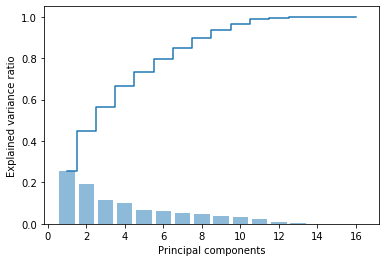

In [22]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.fit_transform(X_test_std)
# pca.explained_variance_ratio_
plt.bar(range(1, 17), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 17), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

In [23]:
pca = PCA(n_components = 13)

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

for label, clf in zip(clf_labels,all_clf):
    print('Model: ',label)
    model_full = clf.fit(X_train, y_train)
    print("Score in original dimension space= :",  model_full.score(X_test,y_test))
    model_pca = clf.fit(X_train_pca, y_train)
    print("Score in reduced dimension= :",  model_pca.score(X_test_pca,y_test), "\n")

Model:  Logistic Regression
Score in original dimension space= : 0.9411764705882353
Score in reduced dimension= : 0.8571428571428571 

Model:  Random Forest
Score in original dimension space= : 0.5882352941176471
Score in reduced dimension= : 0.7310924369747899 

Model:  Gradient Boosting
Score in original dimension space= : 0.7226890756302521
Score in reduced dimension= : 0.8151260504201681 

Model:  KNN
Score in original dimension space= : 0.4957983193277311
Score in reduced dimension= : 0.5378151260504201 



PCA-val jelentős javulás látszik az algoritmusok többségén, viszont a legjobban teljesítő logisztikus regresszió teljesítménye romlik, így nem biztos, hogy érdemes a dimenziócsökkentéssel foglalkozni.

In [24]:
kpca = KernelPCA(n_components=5, kernel='rbf', gamma=15)

X_train_kpca = kpca.fit_transform(X_train)
X_test_kpca = kpca.transform(X_test)

for label, clf in zip(clf_labels,all_clf):
    print('Model: ',label)
    model_full = clf.fit(X_train, y_train)
    print("Score in original dimension space= :",  model_full.score(X_test,y_test))
    model_kpca = clf.fit(X_train_kpca, y_train)
    print("Score in reduced dimension= :",  model_kpca.score(X_test_kpca,y_test), "\n")

Model:  Logistic Regression
Score in original dimension space= : 0.9411764705882353
Score in reduced dimension= : 0.46218487394957986 

Model:  Random Forest
Score in original dimension space= : 0.5882352941176471
Score in reduced dimension= : 0.46218487394957986 

Model:  Gradient Boosting
Score in original dimension space= : 0.7226890756302521
Score in reduced dimension= : 0.46218487394957986 

Model:  KNN
Score in original dimension space= : 0.4957983193277311
Score in reduced dimension= : 0.3277310924369748 



### Forma

$ Forma(t) = \sum \limits _{i=t-n} ^{t} gd(i) * e^{-\lambda(t-i)}$

A gólkülönbség felhasználásval létre lehet hozni egy forma változót, itt az n jelöli a figyelembe vett meccsek számát visszamenőleg. Ezek idővel egyre kevésbé relevánsak, erről gondoskodik az exponenciális tag.

In [25]:
MeccsID = list(range(1, 594))
train_df_id = train_df.copy()
train_df_id["MeccsID"] = MeccsID
train_df_id.head()

,Dátum,HBedobás,HCsapat,HGólok,HKapuraLövés,HKaputEltalálóLövések,HKaputNEMTL,HLabdabirtoklás,HSzabadrúgás,HSzöglet,...,IGólok,IKapuraLövés,IKaputEltalálóLövések,IKaputNEMTL,ILabdabirtoklás,ISzabadrúgás,ISzöglet,IVédés,target,MeccsID
0,2017,30,Paks,2,9,4,5,54,23,9,...,2,10,5,5,46,22,1,2,0,1
1,2017,36,Debreceni VSC,1,18,9,9,48,16,8,...,2,9,6,3,52,20,3,8,-1,2
2,2017,27,Honvéd FC,2,7,5,2,54,24,7,...,0,1,0,1,46,23,1,3,1,3
3,2017,24,Vasas,0,8,4,4,47,25,2,...,2,10,5,5,53,22,3,4,-1,4
4,2017,30,MOL Fehérvár FC,1,14,4,10,56,19,5,...,1,8,3,5,44,11,2,3,0,5


In [26]:
eredmenyek = train_df_id[['MeccsID', 'HCsapat', 'ICsapat', 'HGólok', 'IGólok']].values
gk = gd_vectors(eredmenyek)

idegenbeli_forma_exp, hazai_forma_exp = [], []
for meccs in eredmenyek:
    id, hazai_csapat, idegenbeli_csapat, _, _ = meccs
    idegenbeli_forma_exp.append( exponential_momentum(id, idegenbeli_csapat, gk, alpha = .65) )
    hazai_forma_exp.append( exponential_momentum(id, hazai_csapat, gk, alpha = .65) )

train_df_form = train_df_id.copy()
train_df_form['IForma'] = pd.Series(idegenbeli_forma_exp)
train_df_form['HForma'] = pd.Series(hazai_forma_exp)
train_df_form[-12:-1]

,Dátum,HBedobás,HCsapat,HGólok,HKapuraLövés,HKaputEltalálóLövések,HKaputNEMTL,HLabdabirtoklás,HSzabadrúgás,HSzöglet,...,IKaputEltalálóLövések,IKaputNEMTL,ILabdabirtoklás,ISzabadrúgás,ISzöglet,IVédés,target,MeccsID,IForma,HForma
581,2019,26,MOL Fehérvár FC,1,12,6,6,54,16,6,...,1,4,46,16,5,5,1,582,1.209383,-0.249514
582,2019,26,Újpest,2,10,4,6,49,9,4,...,7,2,51,11,4,2,1,583,1.316623,-0.373499
583,2019,25,Mezőkövesd,0,8,2,6,58,20,6,...,2,4,42,15,1,2,-1,584,1.667104,0.379772
584,2019,26,Kisvárda,1,7,3,4,56,14,8,...,4,2,44,13,5,2,0,585,1.390897,0.107240
585,2019,23,Honvéd FC,4,10,7,3,49,12,4,...,3,7,51,13,6,3,1,586,-0.987093,-1.446881
586,2019,29,Paks,4,13,7,6,47,17,6,...,2,3,53,27,5,3,1,587,-2.787537,-0.226496
587,2019,16,Zalaegerszeg,1,12,7,5,53,23,13,...,9,3,47,11,2,6,0,588,0.391788,0.165292
588,2019,19,Újpest,5,16,11,5,51,14,2,...,2,5,49,11,4,6,1,589,-1.520625,0.249514
589,2019,22,Diósgyőri VTK,0,10,2,8,62,21,14,...,4,3,38,17,2,2,-1,590,0.055984,-2.499314
590,2019,29,Debreceni VSC,1,8,4,4,51,12,9,...,4,1,49,18,4,3,0,591,0.925850,1.469899


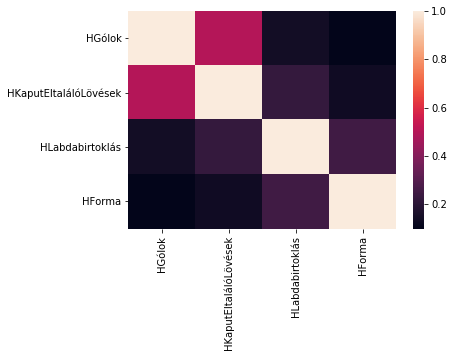

In [27]:
corr = train_df_form[['HGólok', 'HKaputEltalálóLövések','HLabdabirtoklás','HForma']].corr()
_ = sns.heatmap(corr)

### Teljes modell teszteléssel

In [28]:
clfs = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier(),
        KNeighborsClassifier(), GaussianNB(), MLPClassifier(), SVC()]

# először a forma feature nélkül
X = train_df_wo.values
y = train_df['target'].values

run_model_diagnostics(X, y, clfs)

{'LogisticRegression': [('score', 0.9411764705882353)],
 'RandomForestClassifier': [('score', 0.5798319327731093)],
 'GradientBoostingClassifier': [('score', 0.7226890756302521)],
 'KNeighborsClassifier': [('score', 0.4957983193277311)],
 'GaussianNB': [('score', 0.5630252100840336)],
 'MLPClassifier': [('score', 0.773109243697479)],
 'SVC': [('score', 0.46218487394957986)]}

In [29]:
FEATURES_TO_DROP_2 = FEATURES_TO_DROP.copy()
FEATURES_TO_DROP_2.append('MeccsID')
train_df_form_dropped = train_df_form.drop(columns = FEATURES_TO_DROP_2)
X = train_df_form_dropped.values

run_model_diagnostics(X, y, clfs)

{'LogisticRegression': [('score', 0.9411764705882353)],
 'RandomForestClassifier': [('score', 0.5210084033613446)],
 'GradientBoostingClassifier': [('score', 0.7310924369747899)],
 'KNeighborsClassifier': [('score', 0.48739495798319327)],
 'GaussianNB': [('score', 0.5714285714285714)],
 'MLPClassifier': [('score', 0.7142857142857143)],
 'SVC': [('score', 0.46218487394957986)]}

A forma feature bevétele az alapul vett notebookkal ellentétben, hozott javulást néhány esetben, így a további vizsgálodásoknál még vissza lehet térni hozzá.

### Ensemble módszer

In [30]:
eclf = VotingClassifier(estimators=[('lr',LogisticRegression()), ('rf', RandomForestClassifier()), 
                                    ('gb',GradientBoostingClassifier()), ('gnb',GaussianNB())], voting='hard')

scores = cross_val_score(estimator=eclf, X=X_train, y = y_train, cv= 10, scoring = 'accuracy')

print("Ensemble model performance:")
print("Accuracy: %0.2f (+/- %0.2f)"  % (scores.mean(), scores.std()))

Ensemble model performance:
Accuracy: 0.69 (+/- 0.05)


Ez legjobb esetben sem teljesít jobban, mint az eddigi legjobb modell, a logisztikus regresszió.

### Expected Goals

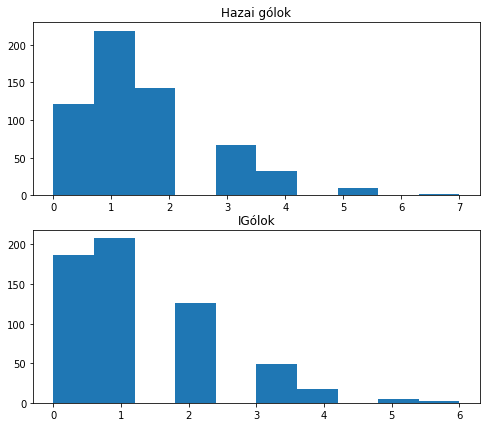

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8,7))

ax1.hist(train_df.HGólok)
ax1.set_title("Hazai gólok")
ax2.hist(train_df.IGólok)
_ = ax2.set_title("IGólok")

A gólok eloszlása úgy tűnik, korábbi vizsgálódásokkal egyetértésben, inkább Poisson vagy exponenciális eloszlást követ.

In [32]:
FEATURES_TO_DROP = ['HBedobás', 'IBedobás', 'HKapuraLövés', 'IKapuraLövés', 'HForma', 'IForma']
TARGET_PROXIES = ['MeccsID', 'Dátum', 'Csapat', 'Gólok']

Most egyelőre elhagytam a formát is, az új infót nem adó kapuralövési adatokat és a látszólag kis korrelációt mutató bedobások számát.

In [33]:
df_c = train_df_form.drop(columns = FEATURES_TO_DROP)
print(list(df_c))

['Dátum', 'HCsapat', 'HGólok', 'HKaputEltalálóLövések', 'HKaputNEMTL', 'HLabdabirtoklás', 'HSzabadrúgás', 'HSzöglet', 'HVédés', 'ICsapat', 'IGólok', 'IKaputEltalálóLövések', 'IKaputNEMTL', 'ILabdabirtoklás', 'ISzabadrúgás', 'ISzöglet', 'IVédés', 'target', 'MeccsID']


In [34]:
hazai_attributumok = ['MeccsID', 'Dátum'] + [a for a in list(df_c) if 'H' in a]
idegenbeli_attributumok = ['MeccsID', 'Dátum'] + [a for a in list(df_c) if 'I' in a]
idegenbeli_attributumok.pop(-1)

print(hazai_attributumok, '\n')
print(idegenbeli_attributumok)

['MeccsID', 'Dátum', 'HCsapat', 'HGólok', 'HKaputEltalálóLövések', 'HKaputNEMTL', 'HLabdabirtoklás', 'HSzabadrúgás', 'HSzöglet', 'HVédés'] 

['MeccsID', 'Dátum', 'ICsapat', 'IGólok', 'IKaputEltalálóLövések', 'IKaputNEMTL', 'ILabdabirtoklás', 'ISzabadrúgás', 'ISzöglet', 'IVédés']


In [35]:
melted = []

for _, row in df_c.iterrows():
    hazai_csapat = [row[attr] for attr in hazai_attributumok] + [1]
    idegenbeli_csapat = [row[attr] for attr in idegenbeli_attributumok] + [0]
    melted.append(hazai_csapat)
    melted.append(idegenbeli_csapat)

print(melted[0])

[1, 2017, 'Paks', 2, 4, 5, 54, 23, 9, 3, 1]


In [36]:
features = ['MeccsID', 'Dátum'] + [a[1:] for a in list(df_c) if 'H' in a] + ['Hazaie']
print(features)

['MeccsID', 'Dátum', 'Csapat', 'Gólok', 'KaputEltalálóLövések', 'KaputNEMTL', 'Labdabirtoklás', 'Szabadrúgás', 'Szöglet', 'Védés', 'Hazaie']


In [37]:
melted_df = pd.DataFrame(melted, columns = features)
melted_df.head(20)

,MeccsID,Dátum,Csapat,Gólok,KaputEltalálóLövések,KaputNEMTL,Labdabirtoklás,Szabadrúgás,Szöglet,Védés,Hazaie
0,1,2017,Paks,2,4,5,54,23,9,3,1
1,1,2017,Újpest,2,5,5,46,22,1,2,0
2,2,2017,Debreceni VSC,1,9,9,48,16,8,4,1
3,2,2017,Mezőkövesd,2,6,3,52,20,3,8,0
4,3,2017,Honvéd FC,2,5,2,54,24,7,0,1
5,3,2017,Haladás,0,0,1,46,23,1,3,0
6,4,2017,Vasas,0,4,4,47,25,2,3,1
7,4,2017,Diósgyőri VTK,2,5,5,53,22,3,4,0
8,5,2017,MOL Fehérvár FC,1,4,10,56,19,5,2,1
9,5,2017,Balmazújváros,1,3,5,44,11,2,3,0


Egy sorban egy csapat adatai szerepelnek, amivel egyszerűbb lesz a modell ehhez a fajta a vizsgálódáshoz.

In [38]:
regressors = [SVR(), MLPRegressor(), KNeighborsRegressor(), Lasso(), LassoLars(), Ridge(), BayesianRidge(),
              SGDRegressor(), AdaBoostRegressor(), ExtraTreesRegressor(), GradientBoostingRegressor(),
              RandomForestRegressor(), LinearRegression()]

In [39]:
melted_df_wo = melted_df.drop(columns = TARGET_PROXIES)

X = melted_df_wo.values
y = melted_df['Gólok'].values

rmse_dict = run_model_diagnostics(X, y, regressors, is_classification = False)

rmse_list = []
for k, v in rmse_dict.items():
    rmse_list.append( (k, v[0][1]) )
sorted(rmse_list, key = lambda x: x[1])

[('LinearRegression', 0.941980112091641),
 ('Ridge', 0.942002196923339),
 ('BayesianRidge', 0.943677977350144),
 ('GradientBoostingRegressor', 0.9501979564269064),
 ('MLPRegressor', 0.9585205032556803),
 ('AdaBoostRegressor', 1.0023580261055887),
 ('RandomForestRegressor', 1.0234347662756342),
 ('ExtraTreesRegressor', 1.0306082482420456),
 ('KNeighborsRegressor', 1.035341862917386),
 ('Lasso', 1.0514455514654797),
 ('SVR', 1.087300289731833),
 ('LassoLars', 1.1659996935195789),
 ('SGDRegressor', 1725014172.376882)]

Az eddig is jónak látott lineáris regresszió mellett a továbbiakban keresztvalidációs tesztelést lehet végezni az alábbi 4 regresszorral.

In [40]:
goal_models_to_consider = {'ridge': Ridge(), 'gb': GradientBoostingRegressor(),
                           'bridge': BayesianRidge(), 'mlp': MLPRegressor()}

In [41]:
ridge_params = {'alpha': [ 10 ** -i for i in range(0,8)]}

ridge_cv = RandomizedSearchCV(goal_models_to_consider['ridge'], ridge_params, cv = 5, n_jobs = -1)
_ = ridge_cv.fit(X, y)

In [42]:
bridge_params = {'alpha_1': [ 10 ** -i for i in range(0,8)],
                 'alpha_2': [ 10 ** -i for i in range(0,8)],
                 'lambda_1': [ 10 ** -i for i in range(0,8)],
                 'lambda_2': [ 10 ** -i for i in range(0,8)]}

bridge_cv = RandomizedSearchCV(goal_models_to_consider['bridge'], bridge_params, cv = 5, n_jobs = -1)
_ = bridge_cv.fit(X, y)

In [43]:
mlp_params = { 'activation' : ['identity', 'logistic', 'tanh', 'relu'],
               'alpha': [ 10 ** -i for i in range(-1,8)],
               'learning_rate': ['constant', 'adaptive']}

mlp_cv = RandomizedSearchCV(goal_models_to_consider['mlp'], mlp_params, cv = 5, n_jobs = -1, n_iter = 20)
_ = mlp_cv.fit(X,y)

In [44]:
join_cv_results(ridge_cv.cv_results_)

{'alpha': 1} :  0.30962
{'alpha': 0.1} :  0.30961
{'alpha': 0.01} :  0.30961
{'alpha': 0.001} :  0.30961
{'alpha': 0.0001} :  0.30961
{'alpha': 1e-05} :  0.30961
{'alpha': 1e-06} :  0.30961
{'alpha': 1e-07} :  0.30961


In [45]:
join_cv_results(bridge_cv.cv_results_)

{'lambda_2': 1e-06, 'lambda_1': 1e-07, 'alpha_2': 1e-07, 'alpha_1': 0.001} :  0.31002
{'lambda_2': 0.01, 'lambda_1': 0.01, 'alpha_2': 0.0001, 'alpha_1': 0.001} :  0.31001
{'lambda_2': 1, 'lambda_1': 0.0001, 'alpha_2': 0.001, 'alpha_1': 1} :  0.30965
{'lambda_2': 0.001, 'lambda_1': 1e-06, 'alpha_2': 0.01, 'alpha_1': 0.1} :  0.31002
{'lambda_2': 1, 'lambda_1': 1, 'alpha_2': 0.1, 'alpha_1': 1e-06} :  0.30966
{'lambda_2': 0.001, 'lambda_1': 0.0001, 'alpha_2': 1e-06, 'alpha_1': 1e-06} :  0.31002
{'lambda_2': 0.001, 'lambda_1': 1, 'alpha_2': 0.01, 'alpha_1': 0.1} :  0.31005
{'lambda_2': 1e-07, 'lambda_1': 1e-05, 'alpha_2': 1e-05, 'alpha_1': 0.1} :  0.31002
{'lambda_2': 0.001, 'lambda_1': 0.1, 'alpha_2': 1, 'alpha_1': 1e-07} :  0.31003
{'lambda_2': 0.1, 'lambda_1': 0.01, 'alpha_2': 1e-06, 'alpha_1': 1e-07} :  0.30985


In [46]:
join_cv_results(mlp_cv.cv_results_)

{'learning_rate': 'adaptive', 'alpha': 1e-06, 'activation': 'logistic'} :  0.32885
{'learning_rate': 'adaptive', 'alpha': 10, 'activation': 'logistic'} :  0.31751
{'learning_rate': 'constant', 'alpha': 1e-06, 'activation': 'relu'} :  0.31821
{'learning_rate': 'adaptive', 'alpha': 1e-06, 'activation': 'identity'} :  0.3012
{'learning_rate': 'constant', 'alpha': 10, 'activation': 'relu'} :  0.30789
{'learning_rate': 'constant', 'alpha': 1e-06, 'activation': 'logistic'} :  0.32864
{'learning_rate': 'constant', 'alpha': 1e-06, 'activation': 'identity'} :  0.31015
{'learning_rate': 'adaptive', 'alpha': 10, 'activation': 'tanh'} :  0.32153
{'learning_rate': 'adaptive', 'alpha': 0.0001, 'activation': 'tanh'} :  0.28797
{'learning_rate': 'constant', 'alpha': 0.001, 'activation': 'tanh'} :  0.29625
{'learning_rate': 'constant', 'alpha': 1e-07, 'activation': 'tanh'} :  0.30581
{'learning_rate': 'adaptive', 'alpha': 0.01, 'activation': 'identity'} :  0.30681
{'learning_rate': 'constant', 'alpha':

In [47]:
gb_params = {'loss': ['ls', 'lad', 'huber'],
             'subsample': [0.2, 0.5, 1.0],
             'min_samples_split': [2, 5, 10],
             'max_depth': [3, 5, 7, 10]}

gb_cv = RandomizedSearchCV(goal_models_to_consider['gb'], gb_params, cv = 5, n_jobs = -1, n_iter = 20)
_ = gb_cv.fit(X,y)

In [48]:
join_cv_results(gb_cv.cv_results_)

{'subsample': 0.2, 'min_samples_split': 5, 'max_depth': 10, 'loss': 'huber'} :  0.06894
{'subsample': 0.5, 'min_samples_split': 10, 'max_depth': 10, 'loss': 'ls'} :  0.09157
{'subsample': 0.5, 'min_samples_split': 10, 'max_depth': 7, 'loss': 'ls'} :  0.12798
{'subsample': 1.0, 'min_samples_split': 2, 'max_depth': 5, 'loss': 'lad'} :  0.2025
{'subsample': 0.2, 'min_samples_split': 2, 'max_depth': 10, 'loss': 'ls'} :  -0.01472
{'subsample': 1.0, 'min_samples_split': 5, 'max_depth': 7, 'loss': 'ls'} :  0.09965
{'subsample': 0.2, 'min_samples_split': 2, 'max_depth': 3, 'loss': 'huber'} :  0.22088
{'subsample': 0.2, 'min_samples_split': 10, 'max_depth': 7, 'loss': 'lad'} :  0.19104
{'subsample': 1.0, 'min_samples_split': 10, 'max_depth': 3, 'loss': 'huber'} :  0.25699
{'subsample': 0.5, 'min_samples_split': 10, 'max_depth': 5, 'loss': 'ls'} :  0.17045
{'subsample': 0.5, 'min_samples_split': 5, 'max_depth': 5, 'loss': 'ls'} :  0.17453
{'subsample': 0.2, 'min_samples_split': 2, 'max_depth': 7

### A modell

Az az alapelképzelés ennél a modellnél, hogy veszünk az előző szezonból n meccset (most n=10), ezek alapján legeneráljuk az első meccs statisztikáit, majd ez az n-es ablak mindig lép tovább a meccsekkel. A generált statisztikákból egy várható gól modellel tippeljük a lőtt gólok számát, ebből pedig már megkaphatók az eredmények.

In [49]:
WINDOW = 10
max(melted_df.Dátum)

2019

In [50]:
unique_teams = melted_df[melted_df.Dátum == 2019].Csapat.unique()
unique_teams

array(['Újpest', 'Puskás Akadémia', 'Mezőkövesd', 'Zalaegerszeg',
       'Kisvárda', 'Paks', 'MOL Fehérvár FC', 'Kaposvár', 'Diósgyőri VTK',
       'Honvéd FC', 'Debreceni VSC', 'Ferencvárosi TC'], dtype=object)

A fent kiszámított loss-ok alapján a Gradient Boosting Regressort használtam a várható gól modellhez. Ez a modell használja majd a többi generált statisztikát.

In [51]:
goal_model = build_exp_goals_model(melted_df, GradientBoostingRegressor(loss = 'huber', max_depth = 10))

In [52]:
features_to_drop = ['MeccsID', 'Csapat', 'Dátum', 'Gólok']

In [53]:
X = melted_df[melted_df.Dátum != 2019].drop(columns = features_to_drop).values
y = melted_df[melted_df.Dátum != 2019]['Gólok'].values
clf = GradientBoostingRegressor(loss = 'ls', max_depth = 10)
clf.fit(X, y)
clf

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [54]:
model_map = {'KaputEltalálóLövések': LinearRegression(),
             'KaputNEMTL': LinearRegression(),
             'Labdabirtoklás': Ridge(),
             'Szabadrúgás': GradientBoostingRegressor(),
             'Szöglet': Ridge(),
             'Védés': GradientBoostingRegressor()}

for feature, clf in model_map.items():
    model_map[feature] = build_game_stats_model(melted_df, clf, feature)

In [55]:
st_dev_map = { feature: np.std(melted_df[feature]) for feature in model_map.keys()}
print(st_dev_map)

{'KaputEltalálóLövések': 2.6259980239301774, 'KaputNEMTL': 2.479777530290671, 'Labdabirtoklás': 5.801377983658268, 'Szabadrúgás': 5.120985969227075, 'Szöglet': 2.88070864431363, 'Védés': 2.2072725484387696}


In [56]:
simulated_df = melted_df[melted_df.Dátum == 2018]
simulated_df.head()
print(simulated_df.Csapat.unique())

['Puskás Akadémia' 'Debreceni VSC' 'MOL Fehérvár FC' 'Kisvárda'
 'Mezőkövesd' 'Paks' 'Honvéd FC' 'Haladás' 'Ferencvárosi TC'
 'Diósgyőri VTK' 'Újpest' 'MTK Budapest']


In [57]:
season_df = melted_df[melted_df.Dátum == 2019].drop(columns = list(model_map.keys()) + ['Gólok'])
season_df.head()

,MeccsID,Dátum,Csapat,Hazaie
790,396,2019,Újpest,1
791,396,2019,Puskás Akadémia,0
792,397,2019,Mezőkövesd,1
793,397,2019,Zalaegerszeg,0
794,398,2019,Kisvárda,1


In [58]:
for row in season_df.iterrows():
    game = row[1]
    simulated_result = fit_game(game, simulated_df, model_map, goal_model, st_dev_map)
    simulated_df = simulated_df.append(simulated_result, ignore_index = True)
    
print(simulated_df.tail())

     MeccsID  Dátum           Csapat  Gólok  KaputEltalálóLövések  KaputNEMTL  \
785      591   2019             Paks      0              0.000000    3.413401   
786      592   2019  Puskás Akadémia      1              4.305874    7.380557   
787      592   2019        Honvéd FC      0              0.767870    1.992406   
788      593   2019  Ferencvárosi TC      1              3.872908    0.000000   
789      593   2019       Mezőkövesd      1              6.229764    0.949488   

     Labdabirtoklás  Szabadrúgás   Szöglet     Védés  Hazaie  
785       48.570245     7.739374  2.485232  2.640799       0  
786       44.205515    22.724267  2.861870  7.856529       1  
787       50.336023    15.168660  4.748086  3.144324       0  
788       48.540725     2.856753  0.000000  1.411659       1  
789       46.324458    18.711472  0.000000  2.849009       0  


In [59]:
ujszezon_sim = simulated_df[simulated_df.Dátum == 2019]
ujszezon_sim['Gólok']= ujszezon_sim['Gólok'].astype(str)
ujszezon_sim.head(10)

,MeccsID,Dátum,Csapat,Gólok,KaputEltalálóLövések,KaputNEMTL,Labdabirtoklás,Szabadrúgás,Szöglet,Védés,Hazaie
394,396,2019,Újpest,2,4.033696,1.304996,55.695369,13.687324,6.180691,0.000000,1
395,396,2019,Puskás Akadémia,2,8.687009,3.715492,44.244814,16.416941,6.519151,0.548254,0
396,397,2019,Mezőkövesd,2,4.631596,1.269128,43.578451,13.418657,0.000000,1.683348,1
397,397,2019,Zalaegerszeg,0,3.392216,0.960754,55.417038,18.779405,7.888001,1.272828,0
398,398,2019,Kisvárda,2,7.930135,3.094710,46.611961,14.884670,0.000000,6.377128,1
399,398,2019,Paks,1,4.510836,1.990256,55.379722,15.257714,7.048414,0.000000,0
400,399,2019,MOL Fehérvár FC,2,4.989152,5.348263,59.911765,15.384795,4.156945,1.726651,1
401,399,2019,Kaposvár,1,2.111046,0.000000,51.982358,19.170829,8.933843,0.000000,0
402,400,2019,Diósgyőri VTK,0,3.057575,4.483659,53.452511,12.500043,8.137361,1.835140,1
403,400,2019,Honvéd FC,1,5.334651,4.694206,54.288270,22.002744,5.743459,2.245748,0


In [60]:
ujszezon_eredmenyek = ujszezon_sim.groupby('MeccsID')['Gólok'].apply(' '.join).reset_index()
ujszezon_csapatok = ujszezon_sim.groupby('MeccsID')['Csapat'].apply(','.join).reset_index()
ujszezon_csapatok.head()

,MeccsID,Csapat
0,396,"Újpest,Puskás Akadémia"
1,397,"Mezőkövesd,Zalaegerszeg"
2,398,"Kisvárda,Paks"
3,399,"MOL Fehérvár FC,Kaposvár"
4,400,"Diósgyőri VTK,Honvéd FC"


In [61]:
ujszezon_eredmenyek = ujszezon_sim.groupby('MeccsID')['Gólok'].apply(' '.join).reset_index()
ujszezon_csapatok = ujszezon_sim.groupby('MeccsID')['Csapat'].apply(','.join).reset_index()
ujszezon_eredmenyek[['HCsapat','ICsapat']] = ujszezon_csapatok.Csapat.str.split(",",expand=True,)
ujszezon_eredmenyek[['HGólok','IGólok']] = ujszezon_eredmenyek.Gólok.str.split(" ",expand=True,)
del ujszezon_eredmenyek['Gólok']
ujszezon_eredmenyek['Eredmények']=list(map(lambda x, y: "H" if x>y else "D" if x==y else "A",
                                        list(df1920["HGólok"]), list(df1920["IGólok"])))
ujszezon_eredmenyek['Prediktált']=list(map(lambda x, y: "H" if x>y else "D" if x==y else "A",
                                        list(ujszezon_eredmenyek["HGólok"]), list(ujszezon_eredmenyek["IGólok"])))
ujszezon_eredmenyek

,MeccsID,HCsapat,ICsapat,HGólok,IGólok,Eredmények,Prediktált
0,396,Újpest,Puskás Akadémia,2,2,A,D
1,397,Mezőkövesd,Zalaegerszeg,2,0,H,H
2,398,Kisvárda,Paks,2,1,H,H
3,399,MOL Fehérvár FC,Kaposvár,2,1,H,H
4,400,Diósgyőri VTK,Honvéd FC,0,1,H,A
5,401,Kaposvár,Mezőkövesd,3,0,A,H
6,402,Diósgyőri VTK,Újpest,0,1,A,A
7,403,Puskás Akadémia,MOL Fehérvár FC,1,2,A,A
8,404,Paks,Honvéd FC,0,0,H,D
9,405,Debreceni VSC,Kisvárda,3,1,H,H


In [65]:
print("Az idegenbeli győzelemnek prediktáltak közül valóban mennyi volt idegenben győzelem.")
print(pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["A"]["A"]/(pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["A"]["A"]+pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["A"]["D"]+pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["A"]["H"]))
print("Az otthoni győzelemnek prediktáltak közül, valóban mennyi volt otthoni győzelem.")
print(pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["H"]["H"]/(pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["H"]["A"]+pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["H"]["D"]+pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["H"]["H"]))
print("--------------------------------------------------------------------------------------------------------------")
print("Az idegenbeli győzelmek közül mennyit találtunk el.")
print(pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["A"]["A"]/(pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["A"]["A"]+pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["D"]["A"]+pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["H"]["A"]))
print("A döntetlenek közül mennyit találtunk el.")
print(pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["D"]["D"]/(pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["A"]["D"]+pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["D"]["D"]+pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["H"]["D"]))
print("Az otthoni győzelmek közül valóban mennyit találtunk el.")
print(pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["H"]["H"]/(pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["A"]["H"]+pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["D"]["H"]+pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["H"]["H"]))
print("--------------------------------------------------------------------------------------------------------------")
print("Összességében mennyit találtunk el.")
print((pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["H"]["H"]+pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["D"]["D"]+pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["A"]["A"])/len(ujszezon_eredmenyek.Eredmények))

Az idegenbeli győzelemnek prediktáltak közül valóban mennyi volt idegenben győzelem.
0.37142857142857144
Az otthoni győzelemnek prediktáltak közül, valóban mennyi volt otthoni győzelem.
0.38461538461538464
--------------------------------------------------------------------------------------------------------------
Az idegenbeli győzelmek közül mennyit találtunk el.
0.38235294117647056
A döntetlenek közül mennyit találtunk el.
0.2727272727272727
Az otthoni győzelmek közül valóban mennyit találtunk el.
0.29069767441860467
--------------------------------------------------------------------------------------------------------------
Összességében mennyit találtunk el.
0.3181818181818182


Ez a modell összességében még jelentősen elmarad az előző Dixon-Coles modell továbbfejlesztésnél, egyes mutatói külön-külön viszont már nem olyan rosszak. Sok apróbb paramétert lehet még variálni (amivel fogok is foglalkozni), illetve bővíthető a modell könnyedén, esetleg több adat hozzávételével, újabb okosan generált featurekkel.